## ***Project 1: PINNs for parametric problems vs Greedy (Advection-Diffusion equation)*** ###

Train a PINN to solve the following parametric problem on
${\Omega} = (0, 1) \times (0, 1)$

$$
\begin{cases}
\nabla \cdot ({\mu_1} \nabla u) + \boldsymbol{\beta}\cdot \nabla{u}= 0 & \text{in } \Omega,\\
{\mu_1} \nabla u \cdot \mathbf{n} = \mu_2 & \text{in } \Gamma_{b},\\
u = 0 & \text{in } \Gamma_{tl},\\
 \nabla u \cdot \mathbf{n} = 0 & \text{otherwise},
\end{cases}
$$

where $\mathbf{n}$ is the outer-normal to the portion of $\partial \Omega$ we consider.
Specifically, $\Gamma_b = [0, 1] \times \{0\}$ and $\Gamma_{tl} = ([0, 1] \times \{1\}) \cup (\{0\} \times [0,1])$.

The convection field is $\boldsymbol{\beta} = [y(1-y),0]^T$ and $(x,y)$ represent a spatial coordinate in $\Omega$.
The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$.


Compare the results with standard ROM based on Greedy approach, both in terms of online  accuracy with respect to the FE solutions, speedups and offline computations compared with the training phase.

**Hints!**

1. Given a neural network $\tilde {w} (\mathbf x)$, the loss will be of the form
  $$
      MSE^{\boldsymbol \mu}  \doteq MSE_b^{\boldsymbol \mu} + MSE_p^{\boldsymbol \mu}.
  $$
  where the boundary MSE is:
  $$
          MSE_b^{\boldsymbol \mu} \doteq \frac{1}{N_b} \sum_{k=1}^{N_b} | \tilde{w}(\mathbf x_k^b) - w(\mathbf x_k^b)|^2,
  $$
  for $\mathbf x_k^b \in \partial \Omega \times \mathcal P$.

  While the physical MSE is
      \begin{equation*}
          MSE_{p}^{\boldsymbol \mu} \doteq \frac{1}{N_p}\sum_{k=1}^{N_p}|\mathcal R(\tilde{w}(\mathbf x_k^p))|^2,
      \end{equation*}

  where $\mathbf x_k^p \in \Omega \times \mathcal P$.
2. Be careful in evaluating the coercivity constant for the greedy procedure.
  For Advection-Diffusion problems the coercivity constant with respect the $H^1_0(\Omega)$ _norm_ can be approximated by
  $$
  \frac{\mu_1}{1 + C_{\Omega}^2},
  $$
  where $C_{\Omega}$ is the Poincaré constant, i.e. the constant verifying
  $$\lvert \lvert u \rvert \rvert_{L^2(\Omega)} \leq C_{\Omega} \lvert \lvert \nabla u \rvert \rvert_{L^2(\Omega)}.$$

  The Poincaré constant can be approximated by the following eigenvalue problem: $ \mathbb X_{H^1_{\text{semi-norm}}} \mathbf x = \lambda \mathbb X_{L^2_{\text{norm}}}\mathbf x$.

  Coding-wise, you can use `scipy` as follows on the inner product and reaction matrix to find $C_{\Omega}$:

In [1]:
from google.colab import files
import numpy as np
import pandas as pd

np.random.seed(2)

#mu2 = np.random.uniform(low = -1., high = 1., size = (80,1))
#mu1 = np.random.exponential(scale=1.0, size=(50,1))
#mu1 = mu1[(mu1 >= 0.1)]
#mu1 = mu1[(mu1 <= 10)]

#xv, yv = np.meshgrid(mu1, mu2)
#xv = xv.reshape((xv.shape[0] * xv.shape[1] ))
#yv = yv.reshape((yv.shape[0] * yv.shape[1] ))

#df = pd.DataFrame(dict(mu1=xv,mu2=yv,ratio=abs(yv/xv)))
#df.describe()

#df.to_csv("data.csv",sep = ';', header=True)
#files.download('./data.csv')

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/data.csv', sep=';')

Mounted at /content/drive


In [7]:
tol_ratio = 1.

df['great'] = np.array(df.ratio >= tol_ratio)

df.describe(include='all')

,Unnamed: 0,mu1,mu2,ratio,great
count,3760.000000,3760.000000,3760.000000,3760.000000,3760
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,2661
mean,1879.500000,0.896672,-0.082362,0.985233,NaN
std,1085.562834,0.726157,0.533643,1.289598,NaN
min,0.000000,0.117189,-0.973965,0.000005,NaN
25%,939.750000,0.320287,-0.486794,0.193948,NaN
50%,1879.500000,0.783828,-0.127258,0.530308,NaN
75%,2819.250000,1.085307,0.239473,1.159774,NaN


# Build a data set

In [8]:
# x and y given as array_like objects
import plotly.express as px
import plotly.graph_objects as go

fig = px.box(df.mu1,points="all")
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()
fig = px.box(df.mu2,points="all")
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

import matplotlib.pyplot as plt



fig = px.scatter(df, x="mu1", y="mu2", color = "ratio")
fig.show()

fig = px.box(df.ratio,points="all")
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()


In [10]:
train=df.sample(frac=0.8,random_state=200)
test=df.drop(train.index)
train.describe(include='all')

,Unnamed: 0,mu1,mu2,ratio,great
count,3008.000000,3008.000000,3008.000000,3008.000000,3008
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,2134
mean,1878.225066,0.902807,-0.085273,0.986252,NaN
std,1094.726990,0.736947,0.531337,1.290127,NaN
min,0.000000,0.117189,-0.973965,0.000005,NaN
25%,927.750000,0.320287,-0.505646,0.196121,NaN
50%,1882.000000,0.783828,-0.128010,0.525531,NaN
75%,2824.250000,1.085307,0.238542,1.149424,NaN


In [9]:
test.describe(include='all')

,Unnamed: 0,mu1,mu2,ratio,great
count,752.000000,752.000000,752.000000,752.000000,752
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,468
mean,1884.599734,0.872130,-0.070717,0.981159,NaN
std,1048.799983,0.681209,0.542968,1.288326,NaN
min,17.000000,0.117189,-0.973965,0.000007,NaN
25%,983.750000,0.349802,-0.480510,0.189687,NaN
50%,1862.500000,0.776945,-0.126505,0.552062,NaN
75%,2790.250000,1.083176,0.251904,1.196361,NaN


In [11]:
!pip install pyevtk

import numpy as np
from pyevtk.hl import pointsToVTK, unstructuredGridToVTK
from pyevtk.vtk import VtkPolygon, VtkLine

def export_cells_0(path_file: str, x: float, y: float, point_data):
    pointsToVTK(path_file, x, y, np.zeros(x.shape), data=point_data)

def export_solution(path_file: str, numeric_solution, cell0DExactSolution, x, y):
    point_data = {"numeric_solution": numeric_solution, "fem_solution": cell0DExactSolution }
    export_cells_0(path_file, x, y, point_data)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Full order model

In [12]:
!git clone https://github.com/fvicini/CppToPython.git
%cd CppToPython

Cloning into 'CppToPython'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 645 (delta 31), reused 50 (delta 17), pack-reused 487
Receiving objects: 100% (645/645), 596.41 KiB | 18.64 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/CppToPython


In [13]:
!git submodule init
!git submodule update

Submodule 'gedim' (https://github.com/fvicini/gedim.git) registered for path 'gedim'
Cloning into '/content/CppToPython/gedim'...
Submodule path 'gedim': checked out 'c52847f1a527d36b529f39d3744afe9fd612b62c'


In [14]:
!mkdir -p externals
%cd externals
!cmake -DINSTALL_VTK=OFF -DINSTALL_LAPACK=OFF ../gedim/3rd_party_libraries
!make -j4
%cd ..

/content/CppToPython/externals
-- The CXX compiler identification is GNU 9.4.0
-- The C compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Install Eigen3 release 3.4.0
-- Install GoogleTest release 1.11.0
-- Install triangle release 1.0.4
-- Install tetgen release 1.0.0
-- Configuring done
-- Generating done
-- Build files have been written to: /content/CppToPython/externals
[  3%] Creating directories for 'triangle'
[  6%] Creating directories for 'Eigen'
[  9%] Creating directories for 'googletest'
[ 12%] Creating directories for 'tetgen'
[ 15%] Performing download step (git clone) for 'triang

In [15]:
!mkdir -p release
%cd release
!cmake -DCMAKE_PREFIX_PATH="/content/CppToPython/externals/Main_Install/eigen3;/content/CppToPython/externals/Main_Install/triangle;/content/CppToPython/externals/Main_Install/tetgen;/content/CppToPython/externals/Main_Install/googletest" ../
!make -j4 GeDiM4Py
%cd ..

/content/CppToPython/release
-- The CXX compiler identification is GNU 9.4.0
-- The C compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Gedim Build configuration: Release
-- Gedim Library will be installed in: /content/CppToPython/release/gedim/GeDiM/GeDiM
-- Looking for sgemm_
-- Looking for sgemm_ - not found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Foun

In [16]:
import numpy as np
import GeDiM4Py as gedim

In [17]:
lib = gedim.ImportLibrary("./release/GeDiM4Py.so")
geometricTolerance = 1.0e-8
config = { 'GeometricTolerance': geometricTolerance }
gedim.Initialize(config, lib)

In [18]:
meshSize = 0.001
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,0,1,1], 'EdgesBoundaryCondition': [2,3,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

#gedim.PlotMesh(mesh)

#df_mesh = pd.DataFrame(mesh.T)
#df_mesh.to_csv('mesh001.csv', sep = ';', header=True)
#files.download('./mesh001.csv')

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2, 3, 3] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
#gedim.PlotDofs(mesh, dofs, strongs)


solution = np.zeros((dofs.shape[1], len(test.mu1)))
count = 0

def Poisson_beta(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values = np.zeros((2, numPoints))
    values[0,:] = (1.0 - matPoints[1,:]) * matPoints[1,:]
    return values.ctypes.data

def Poisson_f(numPoints, points):
    values = np.zeros(numPoints)
    return values.ctypes.data

def Poisson_strongTerm(numPoints, points):
    values = np.zeros(numPoints)
    return values.ctypes.data

def Poisson_diffusion(numPoints, points):
    values = np.ones(numPoints)
    return values.ctypes.data

def Poisson_weakTerm_bottom(numPoints, points):
    values = np.ones(numPoints)
    return values.ctypes.data

[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Poisson_diffusion, problemData, lib)
[advection, advectionStrong] = gedim.AssembleAdvectionMatrix(Poisson_beta, problemData, lib)
forcingTerm = gedim.AssembleForcingTerm(Poisson_f, problemData, lib)
solutionStrong = gedim.AssembleStrongSolution(Poisson_strongTerm, 1, problemData, lib)
weakTerm_bottom = gedim.AssembleWeakTerm(Poisson_weakTerm_bottom, 2, problemData, lib)

for (mu1, mu2) in zip(test.mu1, test.mu2):

    system_matrix = mu1 * stiffness + advection
    rhs = forcingTerm + mu2 * weakTerm_bottom

    solution[:, count] = gedim.LUSolver(system_matrix, rhs, lib)

    count +=1

df_solution = pd.DataFrame(solution)
df_solution.to_csv('solutionValues.csv', sep = ';', header=True)
files.download('./solutionValues.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

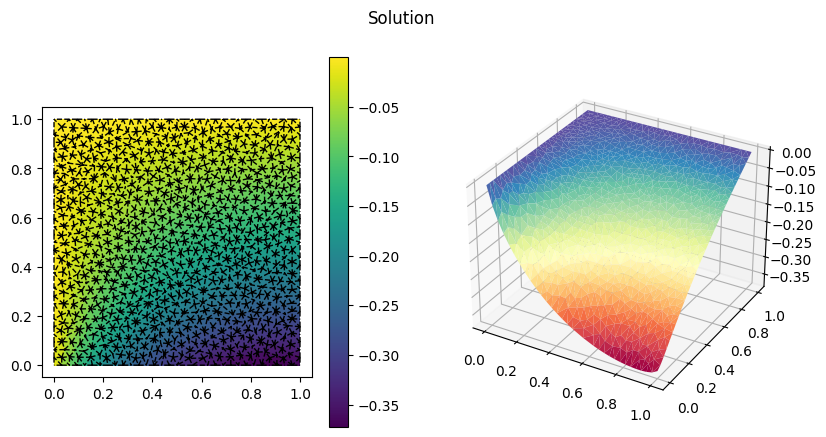

In [19]:
gedim.PlotSolution(mesh, dofs, strongs, solution[:, -1], solutionStrong)

# PINN

## Define a data sets: training and test

In [20]:
df_solution = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/solutionValues.csv', sep=';')

test['max_solution'] = np.array(df_solution.abs().max())[1:]

test.describe()

fig = px.scatter(x=test.ratio, y=test.max_solution)
fig.show()

## Train the NN

In [22]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_nodes = 20
        self.input_layer = nn.Linear(4, num_nodes)
        self.hidden_layer1 = nn.Linear(num_nodes, num_nodes)
        self.hidden_layer2 = nn.Linear(num_nodes, num_nodes)
        self.hidden_layer3 = nn.Linear(num_nodes, num_nodes)
        #self.hidden_layer4 = nn.Linear(num_nodes, num_nodes)
        self.output_layer = nn.Linear(num_nodes, 1)

    def forward(self, x, y, mu1, mu2):
        input = torch.cat([x, y, mu1, mu2],axis=1) # combines the column array
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        #layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer4_out)
        return output


## PDE as loss function. Thus would use the network which we call as u_theta
def R(x, y, mu1, mu2, net):
    u = net(x, y, mu1, mu2) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]

    pde = mu1 * (u_xx + u_yy) + y * (1-y) * u_x

    return pde

def Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net):
    u = net(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom)
    u_x = torch.autograd.grad(u.sum(), pt_x_bc_N_bottom, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), pt_y_bc_N_bottom, create_graph=True)[0]
    neumann = - pt_mu1_N_bottom * u_y - pt_mu2_N_bottom
    return neumann

def Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net):
    u = net(pt_x_bc_N_right,pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right)
    u_x = torch.autograd.grad(u.sum(), pt_x_bc_N_right, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), pt_y_bc_N_right, create_graph=True)[0]
    neumann = u_x
    return neumann

In [ ]:
#@title Testo del titolo predefinito
from numpy.core.multiarray import ndarray
import matplotlib.pyplot as plt
from scipy.stats import qmc

## Data from Boundary Conditions


random_seed = 1
torch.manual_seed(random_seed)

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_D_upper = 500
n_D_left = 500

n_N_bottom = 500
n_N_right = 500
num_points = 500

tol = 1.0e-07
mtol = 1. - 1.0e-07

# Dirichlet upper
# Take n_D_upper random points upper
x_bc_D_upper = np.random.uniform(low=0., high=1., size=(n_D_upper,1))
y_bc_D_upper = np.ones((n_D_upper,1))
# compute u
u_bc_D_upper = np.zeros((n_D_left,1))

x_bc_D_upper = np.ravel(np.squeeze(np.concatenate([([x_bc_D_upper] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
y_bc_D_upper = np.ravel(np.squeeze(np.concatenate([([y_bc_D_upper] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
u_bc_D_upper = np.ravel(np.squeeze(np.concatenate([([u_bc_D_upper] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)

# Dirichlet left
# Take n_D_left random points left
x_bc_D_left = np.zeros((n_D_left,1))
y_bc_D_left = np.random.uniform(low=0., high=1., size=(n_D_left,1))
# compute u
u_bc_D_left = np.zeros((n_D_left,1))

x_bc_D_left = np.ravel(np.squeeze(np.concatenate([([x_bc_D_left] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
y_bc_D_left = np.ravel(np.squeeze(np.concatenate([([y_bc_D_left] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
u_bc_D_left = np.ravel(np.squeeze(np.concatenate([([u_bc_D_left] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)

# Dirichlet v1
x_v1 = np.zeros((n_mu1 * n_mu2, 1))
y_v1 = np.zeros((n_mu1 * n_mu2, 1))
# compute u
u_v1 = np.zeros((n_mu1 * n_mu2, 1))

# Dirichlet v3
x_v3 = np.ones((n_mu1 * n_mu2,1))
y_v3 = np.ones((n_mu1 * n_mu2,1))
# compute u
u_v3 = np.zeros((n_mu1 * n_mu2,1))

# Dirichlet v4
x_v4 = np.zeros((n_mu1 * n_mu2,1))
y_v4 = np.ones((n_mu1 * n_mu2,1))
# compute u
u_v4 = np.zeros((n_mu1 * n_mu2,1))

# Neuman: right
x_bc_N_right = np.ones((n_N_right * n_mu1 * n_mu2,1))
y_bc_N_right = np.random.uniform(low=tol, high=mtol, size=(n_N_right,1))
y_bc_N_right = np.ravel(np.squeeze(np.concatenate([([y_bc_N_right] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)


# Neumann: bottom
x_bc_N_bottom = np.random.uniform(low=tol, high=mtol, size=(n_N_bottom,1))
x_bc_N_bottom = np.ravel(np.squeeze(np.concatenate([([x_bc_N_bottom] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
y_bc_N_bottom = np.zeros((n_N_bottom * n_mu1 * n_mu2,1))


### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error

optimizer = torch.optim.Adam(net.parameters())

### (3) Training / Fitting

print("######### PRETRAIN #############")


iterations = 10000
sampler = qmc.Halton(d=2, scramble=False)
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on vertices:

    mu1_D_v = np.ravel(np.array([mu1] * n_mu2)).reshape(-1,1)
    mu2_D_v = np.ravel(np.concatenate([([mu] * n_mu1 ) for mu in mu2], axis=0)).reshape(-1,1)
    pt_mu1_D_v = Variable(torch.from_numpy(mu1_D_v).float(), requires_grad=False)
    pt_mu2_D_v = Variable(torch.from_numpy(mu2_D_v).float(), requires_grad=False)

    pt_x_v1 = Variable(torch.from_numpy(x_v1).float(), requires_grad=False)
    pt_y_v1 = Variable(torch.from_numpy(y_v1).float(), requires_grad=False)
    pt_u_v1 = Variable(torch.from_numpy(u_v1).float(), requires_grad=False)

    net_v1 = net(pt_x_v1, pt_y_v1, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v1 = mse_cost_function(net_v1, pt_u_v1) # boundary MSE

    pt_x_v3 = Variable(torch.from_numpy(x_v3).float(), requires_grad=False)
    pt_y_v3 = Variable(torch.from_numpy(y_v3).float(), requires_grad=False)
    pt_u_v3 = Variable(torch.from_numpy(u_v3).float(), requires_grad=False)

    net_v3 = net(pt_x_v3, pt_y_v3, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v3 = mse_cost_function(net_v3, pt_u_v3) # boundary MSE

    pt_x_v4 = Variable(torch.from_numpy(x_v4).float(), requires_grad=False)
    pt_y_v4 = Variable(torch.from_numpy(y_v4).float(), requires_grad=False)
    pt_u_v4 = Variable(torch.from_numpy(u_v4).float(), requires_grad=False)

    net_v4 = net(pt_x_v4, pt_y_v4, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v4 = mse_cost_function(net_v4, pt_u_v4) # boundary MSE

    # Loss based on boundary conditions: Dirichlet upper
    mu1_D_upper = np.concatenate([([mu] * n_D_upper) for mu in mu1], axis=0)
    mu1_D_upper = np.reshape(np.repeat(mu1_D_upper, n_mu2, axis=1),(n_D_upper * n_mu1 * n_mu2, 1), order='F')
    mu2_D_upper = np.concatenate([([mu] * n_D_upper) for mu in mu2], axis=0)
    mu2_D_upper = np.ravel(np.repeat(mu2_D_upper, n_mu1)).reshape(-1,1)
    pt_mu1_D_upper = Variable(torch.from_numpy(mu1_D_upper).float(), requires_grad=False)
    pt_mu2_D_upper = Variable(torch.from_numpy(mu2_D_upper).float(), requires_grad=False)

    pt_x_bc_D_upper = Variable(torch.from_numpy(x_bc_D_upper).float(), requires_grad=False)
    pt_y_bc_D_upper = Variable(torch.from_numpy(y_bc_D_upper).float(), requires_grad=False)
    pt_u_bc_D_upper = Variable(torch.from_numpy(u_bc_D_upper).float(), requires_grad=False)

    net_bc_out_D_upper = net(pt_x_bc_D_upper, pt_y_bc_D_upper,pt_mu1_D_upper, pt_mu2_D_upper) # output of u(x,t)
    mse_bc_D_upper = mse_cost_function(net_bc_out_D_upper, pt_u_bc_D_upper) # boundary MSE

    # Loss based on boundary conditions: Dirichlet left
    mu1_D_left = np.concatenate([([mu] * n_D_left) for mu in mu1], axis=0)
    mu1_D_left = np.reshape(np.repeat(mu1_D_left, n_mu2, axis=1),(n_D_left * n_mu1 * n_mu2, 1), order='F')
    mu2_D_left = np.concatenate([([mu] * n_D_left) for mu in mu2], axis=0)
    mu2_D_left = np.ravel(np.repeat(mu2_D_left, n_mu1)).reshape(-1,1)
    pt_mu1_D_left = Variable(torch.from_numpy(mu1_D_left).float(), requires_grad=False)
    pt_mu2_D_left = Variable(torch.from_numpy(mu2_D_left).float(), requires_grad=False)

    pt_x_bc_D_left = Variable(torch.from_numpy(x_bc_D_left).float(), requires_grad=False)
    pt_y_bc_D_left = Variable(torch.from_numpy(y_bc_D_left).float(), requires_grad=False)
    pt_u_bc_D_left = Variable(torch.from_numpy(u_bc_D_left).float(), requires_grad=False)

    net_bc_out_D_left = net(pt_x_bc_D_left, pt_y_bc_D_left, pt_mu1_D_left, pt_mu2_D_left) # output of u(x,t)
    mse_bc_D_left = mse_cost_function(net_bc_out_D_left, pt_u_bc_D_left) # boundary MSE

    # Loss based on boundary conditions: Neumann right
    mu1_N_right = np.concatenate([([mu] * n_N_right) for mu in mu1], axis=0)
    mu1_N_right = np.reshape(np.repeat(mu1_N_right, n_mu2, axis=1),(n_N_right * n_mu1 * n_mu2, 1), order='F')
    mu2_N_right = np.concatenate([([mu] * n_N_right) for mu in mu2], axis=0)
    mu2_N_right = np.ravel(np.repeat(mu2_N_right, n_mu1)).reshape(-1,1)
    pt_mu1_N_right = Variable(torch.from_numpy(mu1_N_right).float(), requires_grad=False)
    pt_mu2_N_right = Variable(torch.from_numpy(mu2_N_right).float(), requires_grad=False)

    pt_x_bc_N_right = Variable(torch.from_numpy(x_bc_N_right).float(), requires_grad=True)
    pt_y_bc_N_right = Variable(torch.from_numpy(y_bc_N_right).float(), requires_grad=True)

    net_neumann_right = Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net)
    zero_n_right = np.zeros((n_N_right * n_mu1 * n_mu2, 1))
    pt_zero_n_right = Variable(torch.from_numpy(zero_n_right).float(), requires_grad=False)
    mse_bc_N_right = mse_cost_function(net_neumann_right, pt_zero_n_right)

    # Loss based on boundary conditions: Neumann bottom
    mu1_N_bottom = np.concatenate([([mu] * n_N_bottom) for mu in mu1], axis=0)
    mu1_N_bottom = np.reshape(np.repeat(mu1_N_bottom, n_mu2, axis=1),(n_N_bottom * n_mu1 * n_mu2, 1), order='F')
    mu2_N_bottom = np.concatenate([([mu] * n_N_bottom) for mu in mu2], axis=0)
    mu2_N_bottom = np.ravel(np.repeat(mu2_N_bottom, n_mu1)).reshape(-1,1)
    pt_mu1_N_bottom = Variable(torch.from_numpy(mu1_N_bottom).float(), requires_grad=False)
    pt_mu2_N_bottom = Variable(torch.from_numpy(mu2_N_bottom).float(), requires_grad=False)

    pt_x_bc_N_bottom = Variable(torch.from_numpy(x_bc_N_bottom).float(), requires_grad=True)
    pt_y_bc_N_bottom = Variable(torch.from_numpy(y_bc_N_bottom).float(), requires_grad=True)

    net_neumann_bottom = Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net)
    zero_n_bottom = np.zeros((n_N_bottom * n_mu1 * n_mu2,1))
    pt_zero_n_bottom = Variable(torch.from_numpy(zero_n_bottom).float(), requires_grad=False)
    mse_bc_N_bottom = mse_cost_function(net_neumann_bottom, pt_zero_n_bottom)

    # Loss based on PDE
    #l_bounds = [tol, tol]
    #u_bounds = [1., 1.]
    #sample = sampler.random(n = num_points)
    #sample = qmc.scale(sample, l_bounds, u_bounds)
    #x_collocation = np.ravel(sample[:,0]).reshape(-1,1)
    #y_collocation = np.ravel(sample[:,1]).reshape(-1,1)
    mu1_collocation = np.concatenate([([mu] * num_points) for mu in mu1], axis=0)
    mu1_collocation = np.reshape(np.repeat(mu1_collocation, n_mu2, axis=1),(num_points * n_mu1 * n_mu2, 1), order='F')
    mu2_collocation = np.concatenate([([mu] * num_points) for mu in mu2], axis=0)
    mu2_collocation = np.ravel(np.repeat(mu2_collocation, n_mu1)).reshape(-1,1)
    pt_mu1_collocation = Variable(torch.from_numpy(mu1_collocation).float(), requires_grad=False)
    pt_mu2_collocation = Variable(torch.from_numpy(mu2_collocation).float(), requires_grad=False)

    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    y_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    x_collocation = np.ravel(np.squeeze(np.concatenate([([x_collocation] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
    y_collocation = np.ravel(np.squeeze(np.concatenate([([y_collocation] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
    all_zeros = np.zeros((num_points * n_mu1 * n_mu2,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)

    f_out = R(pt_x_collocation, pt_y_collocation, pt_mu1_collocation, pt_mu2_collocation, net) # output of R(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    weights = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    loss = (weights[0] * mse_v1 + weights[1] * mse_v3 + weights[2] * mse_v4 + weights[3] * mse_bc_D_upper + weights[4] * mse_bc_D_left + weights[5] * mse_bc_N_bottom + weights[6] * mse_bc_N_right + weights[7] * mse_f)/ np.sum(weights)

    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
      if( epoch % 200 == 0):
        #plt.figure(figsize=(9, 3))
        #plt.subplot(131)
        #plt.plot(x_collocation, y_collocation, 'ro')
        #plt.subplot(132)
        #plt.plot(sample[:,0], sample[:,1], 'ro')
        #plt.axis([0, 1, 0, 1])
        #plt.show()
        print(epoch,"Loss:",loss.item())


In [24]:
from numpy.core.multiarray import ndarray
import matplotlib.pyplot as plt
from scipy.stats import qmc

np.random.seed(2)
random_seed = 1
torch.manual_seed(random_seed)

np.rad2deg

n_D_upper = 1000
n_D_left = 1000

n_N_bottom = 1000
n_N_right = 1000
num_points = 2000

tol = 1.0e-07,
mtol = 1. - 1.0e-07,

# Dirichlet upper
# Take n_D_upper random points upper
x_bc_D_upper = np.random.uniform(low=0., high=1., size=(n_D_upper,1))
y_bc_D_upper = np.ones((n_D_upper,1))
# compute u
u_bc_D_upper = np.zeros((n_D_left,1))


# Dirichlet left
# Take n_D_left random points left
x_bc_D_left = np.zeros((n_D_left,1))
y_bc_D_left = np.random.uniform(low=0., high=1., size=(n_D_left,1))
# compute u
u_bc_D_left = np.zeros((n_D_left,1))


# Dirichlet v1
x_v1 = np.zeros((1, 1))
y_v1 = np.zeros((1, 1))
# compute u
u_v1 = np.zeros((1, 1))

# Dirichlet v3
x_v3 = np.ones((1, 1))
y_v3 = np.ones((1, 1))
# compute u
u_v3 = np.zeros((1, 1))

# Dirichlet v4
x_v4 = np.zeros((1, 1))
y_v4 = np.ones((1, 1))
# compute u
u_v4 = np.zeros((1, 1))


# Neuman: right
x_bc_N_right = np.ones((n_N_right,1))
y_bc_N_right = np.random.uniform(low=tol, high=mtol, size=(n_N_right,1))


# Neumann: bottom
x_bc_N_bottom = np.random.uniform(low=tol, high=mtol, size=(n_N_bottom,1))
y_bc_N_bottom = np.zeros((n_N_bottom ,1))

### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())


### (3) Training / Fitting

print("######### TRAIN #############")


iterations = 10000
#sampler = qmc.Halton(d=2, scramble=False)
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on vertices:
    minibatch=train.sample(n = 1)
    mu1_D_v = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_v = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_v = Variable(torch.from_numpy(mu1_D_v).float(), requires_grad=False)
    pt_mu2_D_v = Variable(torch.from_numpy(mu2_D_v).float(), requires_grad=False)

    pt_x_v1 = Variable(torch.from_numpy(x_v1).float(), requires_grad=False)
    pt_y_v1 = Variable(torch.from_numpy(y_v1).float(), requires_grad=False)
    pt_u_v1 = Variable(torch.from_numpy(u_v1).float(), requires_grad=False)

    net_v1 = net(pt_x_v1, pt_y_v1, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v1 = mse_cost_function(net_v1, pt_u_v1) # boundary MSE

    minibatch=train.sample(n = 1)
    mu1_D_v = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_v = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_v = Variable(torch.from_numpy(mu1_D_v).float(), requires_grad=False)
    pt_mu2_D_v = Variable(torch.from_numpy(mu2_D_v).float(), requires_grad=False)

    pt_x_v3 = Variable(torch.from_numpy(x_v3).float(), requires_grad=False)
    pt_y_v3 = Variable(torch.from_numpy(y_v3).float(), requires_grad=False)
    pt_u_v3 = Variable(torch.from_numpy(u_v3).float(), requires_grad=False)

    net_v3 = net(pt_x_v3, pt_y_v3, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v3 = mse_cost_function(net_v3, pt_u_v3) # boundary MSE

    minibatch=train.sample(n = 1)
    mu1_D_v = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_v = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_v = Variable(torch.from_numpy(mu1_D_v).float(), requires_grad=False)
    pt_mu2_D_v = Variable(torch.from_numpy(mu2_D_v).float(), requires_grad=False)

    pt_x_v4 = Variable(torch.from_numpy(x_v4).float(), requires_grad=False)
    pt_y_v4 = Variable(torch.from_numpy(y_v4).float(), requires_grad=False)
    pt_u_v4 = Variable(torch.from_numpy(u_v4).float(), requires_grad=False)

    net_v4 = net(pt_x_v4, pt_y_v4, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v4 = mse_cost_function(net_v4, pt_u_v4) # boundary MSE

    # Loss based on boundary conditions: Dirichlet upper
    minibatch=train.sample(n = n_D_upper)
    mu1_D_upper = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_upper = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_upper = Variable(torch.from_numpy(mu1_D_upper).float(), requires_grad=False)
    pt_mu2_D_upper = Variable(torch.from_numpy(mu2_D_upper).float(), requires_grad=False)

    pt_x_bc_D_upper = Variable(torch.from_numpy(x_bc_D_upper).float(), requires_grad=False)
    pt_y_bc_D_upper = Variable(torch.from_numpy(y_bc_D_upper).float(), requires_grad=False)
    pt_u_bc_D_upper = Variable(torch.from_numpy(u_bc_D_upper).float(), requires_grad=False)

    net_bc_out_D_upper = net(pt_x_bc_D_upper, pt_y_bc_D_upper,pt_mu1_D_upper, pt_mu2_D_upper) # output of u(x,t)
    mse_bc_D_upper = mse_cost_function(net_bc_out_D_upper, pt_u_bc_D_upper) # boundary MSE

    # Loss based on boundary conditions: Dirichlet left
    minibatch=train.sample(n = n_D_left)
    mu1_D_left = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_left = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_left = Variable(torch.from_numpy(mu1_D_left).float(), requires_grad=False)
    pt_mu2_D_left = Variable(torch.from_numpy(mu2_D_left).float(), requires_grad=False)

    pt_x_bc_D_left = Variable(torch.from_numpy(x_bc_D_left).float(), requires_grad=False)
    pt_y_bc_D_left = Variable(torch.from_numpy(y_bc_D_left).float(), requires_grad=False)
    pt_u_bc_D_left = Variable(torch.from_numpy(u_bc_D_left).float(), requires_grad=False)

    net_bc_out_D_left = net(pt_x_bc_D_left, pt_y_bc_D_left, pt_mu1_D_left, pt_mu2_D_left) # output of u(x,t)
    mse_bc_D_left = mse_cost_function(net_bc_out_D_left, pt_u_bc_D_left) # boundary MSE

    # Loss based on boundary conditions: Neumann right
    minibatch=train.sample(n = n_N_right)
    mu1_N_right = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_N_right = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_N_right = Variable(torch.from_numpy(mu1_N_right).float(), requires_grad=False)
    pt_mu2_N_right = Variable(torch.from_numpy(mu2_N_right).float(), requires_grad=False)

    pt_x_bc_N_right = Variable(torch.from_numpy(x_bc_N_right).float(), requires_grad=True)
    pt_y_bc_N_right = Variable(torch.from_numpy(y_bc_N_right).float(), requires_grad=True)

    net_neumann_right = Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net)
    zero_n_right = np.zeros((n_N_right , 1))
    pt_zero_n_right = Variable(torch.from_numpy(zero_n_right).float(), requires_grad=False)
    mse_bc_N_right = mse_cost_function(net_neumann_right, pt_zero_n_right)

    # Loss based on boundary conditions: Neumann bottom
    minibatch=train.sample(n = n_N_bottom)
    mu1_N_bottom = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_N_bottom = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_N_bottom = Variable(torch.from_numpy(mu1_N_bottom).float(), requires_grad=False)
    pt_mu2_N_bottom = Variable(torch.from_numpy(mu2_N_bottom).float(), requires_grad=False)

    pt_x_bc_N_bottom = Variable(torch.from_numpy(x_bc_N_bottom).float(), requires_grad=True)
    pt_y_bc_N_bottom = Variable(torch.from_numpy(y_bc_N_bottom).float(), requires_grad=True)

    net_neumann_bottom = Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net)
    zero_n_bottom = np.zeros((n_N_bottom ,1))
    pt_zero_n_bottom = Variable(torch.from_numpy(zero_n_bottom).float(), requires_grad=False)
    mse_bc_N_bottom = mse_cost_function(net_neumann_bottom, pt_zero_n_bottom)

    # Loss based on PDE
    #l_bounds = [tol, tol]
    #u_bounds = [1., 1.]
    #sample = sampler.random(n = num_points)
    #sample = qmc.scale(sample, l_bounds, u_bounds)
    #x_collocation = np.ravel(sample[:,0]).reshape(-1,1)
    #y_collocation = np.ravel(sample[:,1]).reshape(-1,1)
    minibatch=train.sample(n = num_points)
    mu1_collocation = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_collocation = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_collocation = Variable(torch.from_numpy(mu1_collocation).float(), requires_grad=False)
    pt_mu2_collocation = Variable(torch.from_numpy(mu2_collocation).float(), requires_grad=False)

    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    y_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    all_zeros = np.zeros((num_points,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)

    f_out = R(pt_x_collocation, pt_y_collocation, pt_mu1_collocation, pt_mu2_collocation, net) # output of R(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    weights = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    loss = (weights[0] * mse_v1 + weights[1] * mse_v3 + weights[2] * mse_v4 + weights[3] * mse_bc_D_upper + weights[4] * mse_bc_D_left + weights[5] * mse_bc_N_bottom + weights[6] * mse_bc_N_right + weights[7] * mse_f)/ np.sum(weights)

    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
      if( epoch % 200 == 0):
        #plt.figure(figsize=(9, 3))
        #plt.subplot(131)
        #plt.plot(x_collocation, y_collocation, 'ro')
        #plt.subplot(132)
        #plt.plot(sample[:,0], sample[:,1], 'ro')
        #plt.axis([0, 1, 0, 1])
        #plt.show()
        print(epoch,"Loss:",loss.item())

######### TRAIN #############
0 Loss: 0.37264421582221985
200 Loss: 0.03627151623368263
400 Loss: 0.03633247688412666
600 Loss: 0.03817273676395416
800 Loss: 0.03661097586154938
1000 Loss: 0.03525981679558754
1200 Loss: 0.03283281624317169
1400 Loss: 0.029383350163698196
1600 Loss: 0.027194522321224213
1800 Loss: 0.021557249128818512
2000 Loss: 0.02377275563776493
2200 Loss: 0.02032277174293995
2400 Loss: 0.01970626227557659
2600 Loss: 0.015548864379525185
2800 Loss: 0.019162029027938843
3000 Loss: 0.011494293808937073
3200 Loss: 0.014161364175379276
3400 Loss: 0.013982228934764862
3600 Loss: 0.010944763198494911
3800 Loss: 0.012775285169482231
4000 Loss: 0.011010115034878254
4200 Loss: 0.009592948481440544
4400 Loss: 0.009344985708594322
4600 Loss: 0.013256644830107689
4800 Loss: 0.012835023924708366
5000 Loss: 0.00830776710063219
5200 Loss: 0.009415597654879093
5400 Loss: 0.009427661076188087
5600 Loss: 0.011238341219723225
5800 Loss: 0.008669096976518631
6000 Loss: 0.008579567074775

In [51]:
from numpy.core.multiarray import ndarray
import matplotlib.pyplot as plt
from scipy.stats import qmc

np.random.seed(2)
random_seed = 1
torch.manual_seed(random_seed)

np.rad2deg

n_D_upper = 1000
n_D_left = 1000

n_N_bottom = 1000
n_N_right = 1000
num_points = 2000

tol = 1.0e-07,
mtol = 1. - 1.0e-07,

# Dirichlet upper
# Take n_D_upper random points upper
x_bc_D_upper = np.ravel(np.linspace(0.0, 1.0, num = n_D_upper)).reshape(-1,1)
y_bc_D_upper = np.ones((n_D_upper,1))
# compute u
u_bc_D_upper = np.zeros((n_D_left,1))


# Dirichlet left
# Take n_D_left random points left
x_bc_D_left = np.zeros((n_D_left,1))
y_bc_D_left = np.ravel(np.linspace(0.0, 1.0, num = n_D_left)).reshape(-1,1)
# compute u
u_bc_D_left = np.zeros((n_D_left,1))


# Neuman: right
x_bc_N_right = np.ones((n_N_right,1))
y_bc_N_right = np.ravel(np.linspace(tol, mtol, num = n_D_left)).reshape(-1,1)


# Neumann: bottom
x_bc_N_bottom = np.ravel(np.linspace(tol, mtol, num = n_D_left)).reshape(-1,1)
y_bc_N_bottom = np.zeros((n_N_bottom ,1))

### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())


### (3) Training / Fitting

print("######### TRAIN 2 alternativa #############")


iterations = 10000
sampler = qmc.Halton(d=2, scramble=False)
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on boundary conditions: Dirichlet upper
    minibatch=train.sample(n = n_D_upper)
    mu1_D_upper = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_upper = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_upper = Variable(torch.from_numpy(mu1_D_upper).float(), requires_grad=False)
    pt_mu2_D_upper = Variable(torch.from_numpy(mu2_D_upper).float(), requires_grad=False)

    pt_x_bc_D_upper = Variable(torch.from_numpy(x_bc_D_upper).float(), requires_grad=False)
    pt_y_bc_D_upper = Variable(torch.from_numpy(y_bc_D_upper).float(), requires_grad=False)
    pt_u_bc_D_upper = Variable(torch.from_numpy(u_bc_D_upper).float(), requires_grad=False)

    net_bc_out_D_upper = net(pt_x_bc_D_upper, pt_y_bc_D_upper,pt_mu1_D_upper, pt_mu2_D_upper) # output of u(x,t)
    mse_bc_D_upper = mse_cost_function(net_bc_out_D_upper, pt_u_bc_D_upper) # boundary MSE

    # Loss based on boundary conditions: Dirichlet left
    minibatch=train.sample(n = n_D_left)
    mu1_D_left = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_D_left = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_D_left = Variable(torch.from_numpy(mu1_D_left).float(), requires_grad=False)
    pt_mu2_D_left = Variable(torch.from_numpy(mu2_D_left).float(), requires_grad=False)

    pt_x_bc_D_left = Variable(torch.from_numpy(x_bc_D_left).float(), requires_grad=False)
    pt_y_bc_D_left = Variable(torch.from_numpy(y_bc_D_left).float(), requires_grad=False)
    pt_u_bc_D_left = Variable(torch.from_numpy(u_bc_D_left).float(), requires_grad=False)

    net_bc_out_D_left = net(pt_x_bc_D_left, pt_y_bc_D_left, pt_mu1_D_left, pt_mu2_D_left) # output of u(x,t)
    mse_bc_D_left = mse_cost_function(net_bc_out_D_left, pt_u_bc_D_left) # boundary MSE

    # Loss based on boundary conditions: Neumann right
    minibatch=train.sample(n = n_N_right)
    mu1_N_right = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_N_right = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_N_right = Variable(torch.from_numpy(mu1_N_right).float(), requires_grad=False)
    pt_mu2_N_right = Variable(torch.from_numpy(mu2_N_right).float(), requires_grad=False)

    pt_x_bc_N_right = Variable(torch.from_numpy(x_bc_N_right).float(), requires_grad=True)
    pt_y_bc_N_right = Variable(torch.from_numpy(y_bc_N_right).float(), requires_grad=True)

    net_neumann_right = Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net)
    zero_n_right = np.zeros((n_N_right , 1))
    pt_zero_n_right = Variable(torch.from_numpy(zero_n_right).float(), requires_grad=False)
    mse_bc_N_right = mse_cost_function(net_neumann_right, pt_zero_n_right)

    # Loss based on boundary conditions: Neumann bottom
    minibatch=train.sample(n = n_N_bottom)
    mu1_N_bottom = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_N_bottom = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_N_bottom = Variable(torch.from_numpy(mu1_N_bottom).float(), requires_grad=False)
    pt_mu2_N_bottom = Variable(torch.from_numpy(mu2_N_bottom).float(), requires_grad=False)

    pt_x_bc_N_bottom = Variable(torch.from_numpy(x_bc_N_bottom).float(), requires_grad=True)
    pt_y_bc_N_bottom = Variable(torch.from_numpy(y_bc_N_bottom).float(), requires_grad=True)

    net_neumann_bottom = Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net)
    zero_n_bottom = np.zeros((n_N_bottom ,1))
    pt_zero_n_bottom = Variable(torch.from_numpy(zero_n_bottom).float(), requires_grad=False)
    mse_bc_N_bottom = mse_cost_function(net_neumann_bottom, pt_zero_n_bottom)

    # Loss based on PDE
    minibatch=train.sample(n = num_points)
    mu1_collocation = np.ravel(np.array(minibatch.mu1)).reshape(-1,1)
    mu2_collocation = np.ravel(np.array(minibatch.mu2)).reshape(-1,1)
    pt_mu1_collocation = Variable(torch.from_numpy(mu1_collocation).float(), requires_grad=False)
    pt_mu2_collocation = Variable(torch.from_numpy(mu2_collocation).float(), requires_grad=False)

    #l_bounds = [tol, tol]
    #u_bounds = [1., 1.]
    sample = sampler.random(n = num_points)
    #sample = qmc.scale(sample, l_bounds, u_bounds)
    x_collocation = np.ravel(sample[:,0]).reshape(-1,1)
    y_collocation = np.ravel(sample[:,1]).reshape(-1,1)
    #x_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    #y_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    all_zeros = np.zeros((num_points,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)

    f_out = R(pt_x_collocation, pt_y_collocation, pt_mu1_collocation, pt_mu2_collocation, net) # output of R(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    weights = np.array([1, 1, 1, 1, 1])
    loss = (weights[0] * mse_bc_D_upper + weights[1] * mse_bc_D_left + weights[2] * mse_bc_N_bottom + weights[3] * mse_bc_N_right + weights[4] * mse_f)/ np.sum(weights)

    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
      if( epoch % 200 == 0):
        #plt.figure(figsize=(9, 3))
        #plt.subplot(131)
        #plt.plot(x_collocation, y_collocation, 'ro')
        #plt.subplot(132)
        #plt.plot(sample[:,0], sample[:,1], 'ro')
        #plt.axis([0, 1, 0, 1])
        #plt.show()
        print(epoch,"Loss:",loss.item())

######### TRAIN 2 alternativa #############
0 Loss: 0.2749125361442566
200 Loss: 0.05770101025700569
400 Loss: 0.05919202044606209
600 Loss: 0.05822055786848068
800 Loss: 0.05379779264330864
1000 Loss: 0.046034716069698334
1200 Loss: 0.031118661165237427
1400 Loss: 0.023411059752106667
1600 Loss: 0.019130466505885124
1800 Loss: 0.015969786792993546
2000 Loss: 0.013287571258842945
2200 Loss: 0.010939407162368298
2400 Loss: 0.010460959747433662
2600 Loss: 0.009259984828531742
2800 Loss: 0.007651880383491516
3000 Loss: 0.007466556038707495
3200 Loss: 0.006424729712307453
3400 Loss: 0.005506666377186775
3600 Loss: 0.004676564130932093
3800 Loss: 0.0044028135016560555
4000 Loss: 0.004551498685032129
4200 Loss: 0.0036949242930859327
4400 Loss: 0.0034408860374242067
4600 Loss: 0.0030953744426369667
4800 Loss: 0.003092058701440692
5000 Loss: 0.002789480611681938
5200 Loss: 0.0024466756731271744
5400 Loss: 0.00253303162753582
5600 Loss: 0.0024752470199018717
5800 Loss: 0.002344124484807253
6000

In [53]:
from numpy import linalg

num_mu1 = len(test.mu1)
errors = np.zeros(num_mu1)
max_NN_sol = np.zeros(num_mu1)

count = 0
for (mu1,mu2) in zip(test.mu1, test.mu2):
  x = mesh[0,:].T
  y = mesh[1,:].T
  x_reshape = np.ravel(x).reshape(-1,1)
  y_reshape = np.ravel(y).reshape(-1,1)
  pt_mu1_test = Variable(torch.from_numpy(mu1 * np.ones((x.shape[0], 1))).float(), requires_grad=True)
  pt_mu2_test = Variable(torch.from_numpy(mu2 * np.ones((x.shape[0], 1))).float(), requires_grad=True)
  pt_x = Variable(torch.from_numpy(x_reshape).float(), requires_grad=True)
  pt_y = Variable(torch.from_numpy(y_reshape).float(), requires_grad=True)
  pt_u = net(pt_x,pt_y, pt_mu1_test, pt_mu2_test)
  nn_solution = np.squeeze(pt_u.detach().numpy())
  max_NN_sol[count] = np.absolute(nn_solution).max()

  fem_solution = np.zeros(x.shape)
  count +=1
  num_solution = np.array(df_solution[df_solution.columns[count]])
  count_dof = 0
  count_strong = 0
  for i in range(len(fem_solution)):
      if abs(x[i]) < geometricTolerance or abs(y[i] - 1.) < geometricTolerance:
          fem_solution[i] = 0.
          count_strong += 1
      else:
          fem_solution[i] = num_solution[count_dof]
          count_dof += 1

  if (count == 708):
    export_solution('./solutionFig', nn_solution, fem_solution, x, y)
    from google.colab import files
    files.download('./solutionFig.vtu')

  # compute errors
  errors[count-1] = linalg.norm(nn_solution - fem_solution) / len((fem_solution))
  print('error sol ', count , ' : ', errors[count-1])

error sol  1  :  0.0003546944804266716
error sol  2  :  0.00016144565954256197
error sol  3  :  0.0007842525055469322
error sol  4  :  0.0006622802069253776
error sol  5  :  0.0008085175428383028
error sol  6  :  0.0007435166435814507
error sol  7  :  0.00099841707528337
error sol  8  :  0.016564424722312756
error sol  9  :  0.004890614247835635
error sol  10  :  0.0008117712866221652
error sol  11  :  0.00023484890462908278
error sol  12  :  0.004769089982845814
error sol  13  :  0.0005100785957278011
error sol  14  :  0.0004274503866898343
error sol  15  :  0.00035219182780641995
error sol  16  :  0.00024167124951405088
error sol  17  :  0.0005738032915464069
error sol  18  :  0.0009970270530387574
error sol  19  :  0.0001867364507295492
error sol  20  :  0.00023559337871471639
error sol  21  :  0.0005742904194930956
error sol  22  :  0.00016134610768895832
error sol  23  :  0.00011046788095288011
error sol  24  :  0.00036570380384286195
error sol  25  :  0.0002574542169203653
error 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

error sol  708  :  0.019629882751096037
error sol  709  :  0.0004030900557648301
error sol  710  :  0.0009289022426152898
error sol  711  :  0.0013024247785491884
error sol  712  :  0.0003999412445684236
error sol  713  :  0.0016516673692831775
error sol  714  :  0.0003975732788243509
error sol  715  :  0.0013786170333923563
error sol  716  :  0.001899909039917623
error sol  717  :  0.0001527276941699343
error sol  718  :  0.00011498643869306949
error sol  719  :  0.000644273415615059
error sol  720  :  0.0003607001036162006
error sol  721  :  0.00021113337894933658
error sol  722  :  0.0006854186423401823
error sol  723  :  0.0007120462583715418
error sol  724  :  0.0005019460239583881
error sol  725  :  0.000742829498034777
error sol  726  :  0.0026677203481078895
error sol  727  :  0.0035115613419372015
error sol  728  :  0.004393389302962769
error sol  729  :  0.004995262711739516
error sol  730  :  0.0007269144274885959
error sol  731  :  0.0006373137858702898
error sol  732  :  0

In [54]:
pd.DataFrame(errors).describe()

,0
count,752.000000
mean,0.001398
std,0.002911
min,0.000081
25%,0.000265
50%,0.000520
75%,0.001230
max,0.028639


In [55]:
test['max__NN_solution'] = max_NN_sol

test.describe()

fig = px.scatter(x=test.ratio, y=test.max__NN_solution)
fig.show()

# Greedy approach

In [ ]:
#import scipy

#eigs, vecs = scipy.linalg.eig(stiffness.todense(), mass.todense())
#min_eig = np.min(eigs.real)

#C_omega = 1 / np.sqrt(min_eig)